In [9]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Tsukuba Modelling

### Loading in Tsukuba Dataset

In [93]:
tsukuba = pd.read_csv("data/tsukuba_ac.csv").iloc[:,:24]

def lt_in_seconds(time):
    print(time)
    
    minutes, seconds = time.strip().split(':')
    return 60*np.float64(minutes) + np.float64(seconds)
    

tsukuba_irl = (
    tsukuba.loc[tsukuba['Source']=='irl']
    .drop(columns=['Author']))

tsukuba_ac = tsukuba.loc[tsukuba['Source']!='irl']

In [95]:
tsukuba['Lap Time III'].fillna('0:00.000').apply(lt_in_seconds)

0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0:00.000
0

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1454    0.0
1455    0.0
1456    0.0
1457    0.0
1458    0.0
Name: Lap Time III, Length: 1459, dtype: float64

In [91]:
tsukuba['Lap Time II'].



False

In [26]:
txt = " ({numcar} cars)"

print("Datasets:\n")
print("All Tsukuba Data"+txt.format(numcar = tsukuba.shape[0]))
display(tsukuba.head())
print()
print("\nReal Life Data Only"+txt.format(numcar = tsukuba_irl.shape[0]))
display(tsukuba_irl.head())
print("\nAssetto Corsa Data"+txt.format(numcar = tsukuba_ac.shape[0]))
display(tsukuba_ac.head())

Datasets:

All Tsukuba Data (1459 cars)


,Year,Brand,Model,Lap Time I,RC,Tire II,Lap Time II,RC,Tire III,Lap Time III,...,WTorque,Weight,P/W (kg/hp),Layout,Trans,Rating,_HD,Author,Source,Comments / Other Times
0,2016.0,Abarth,124 Spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,1070.0,6.045198,FR,MT,NaN,L,?,link,NaN
1,2008.0,Abarth,500 EsseEsse,1:11.907,0.0,SM,1:11.065,1.0,NaN,NaN,...,205.0,1025.0,7.167832,FF,MT,3.5,L,Kunos,AC,NaN
2,2008.0,Abarth,500 EsseEsse,1:12.997,0.0,NaN,NaN,NaN,NaN,NaN,...,206.0,1092.0,8.088889,FF,MT,NaN,L,Abarth,irl,NaN
3,2017.0,Abarth,595 Pista,1:11.661,0.0,NaN,NaN,NaN,NaN,NaN,...,252.0,1025.0,5.662983,FF,MT,3.0,L,Simaothekid,link,hp too high for whp
4,1964.0,Abarth,595 SS,1:31.018,0.0,NaN,NaN,NaN,NaN,NaN,...,38.0,470.0,16.785714,RR,MT,3.0,L,Kunos,AC,NaN




Real Life Data Only (231 cars)


,Year,Brand,Model,Lap Time I,RC,Tire II,Lap Time II,RC,Tire III,Lap Time III,...,WHP,WTorque,Weight,P/W (kg/hp),Layout,Trans,Rating,_HD,Source,Comments / Other Times
2,2008.0,Abarth,500 EsseEsse,1:12.997,0.0,NaN,NaN,NaN,NaN,NaN,...,135.0,206.0,1092.0,8.088889,FF,MT,NaN,L,irl,NaN
32,2003.0,Alfa Romeo,156 GTA,1:12.900,0.0,NaN,NaN,NaN,NaN,NaN,...,242.0,277.0,1410.0,5.826446,RR,MT,NaN,L,irl,NaN
53,2017.0,Alpine,A110,1:05.04,0.0,NaN,NaN,NaN,NaN,NaN,...,234.0,317.0,1111.0,4.747863,MR,AT,NaN,L,irl,NaN
76,2006.0,Audi,R8 4.2 FSI,1:03.88,0.0,NaN,NaN,NaN,NaN,NaN,...,354.0,376.0,1604.0,4.265957,M4,AT,NaN,L,irl,NaN
77,2009.0,Audi,R8 V10 5.2 FSI,1:04.87,0.0,NaN,NaN,NaN,NaN,NaN,...,485.0,474.0,1671.0,3.445361,M4,AT,NaN,L,irl,NaN



Assetto Corsa Data (1228 cars)


,Year,Brand,Model,Lap Time I,RC,Tire II,Lap Time II,RC,Tire III,Lap Time III,...,WTorque,Weight,P/W (kg/hp),Layout,Trans,Rating,_HD,Author,Source,Comments / Other Times
0,2016.0,Abarth,124 Spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,271.0,1070.0,6.045198,FR,MT,NaN,L,?,link,NaN
1,2008.0,Abarth,500 EsseEsse,1:11.907,0.0,SM,1:11.065,1.0,NaN,NaN,...,205.0,1025.0,7.167832,FF,MT,3.5,L,Kunos,AC,NaN
3,2017.0,Abarth,595 Pista,1:11.661,0.0,NaN,NaN,NaN,NaN,NaN,...,252.0,1025.0,5.662983,FF,MT,3.0,L,Simaothekid,link,hp too high for whp
4,1964.0,Abarth,595 SS,1:31.018,0.0,NaN,NaN,NaN,NaN,NaN,...,38.0,470.0,16.785714,RR,MT,3.0,L,Kunos,AC,NaN
5,2009.0,Abarth,Punto,1:11.601,0.0,NaN,NaN,NaN,NaN,NaN,...,230.0,1260.0,7.544910,FF,MT,3.5,L,Simaothekid,link,NaN


In [12]:
assert tsukuba_ac.shape[0] + tsukuba_irl.shape[0] == tsukuba.shape[0]

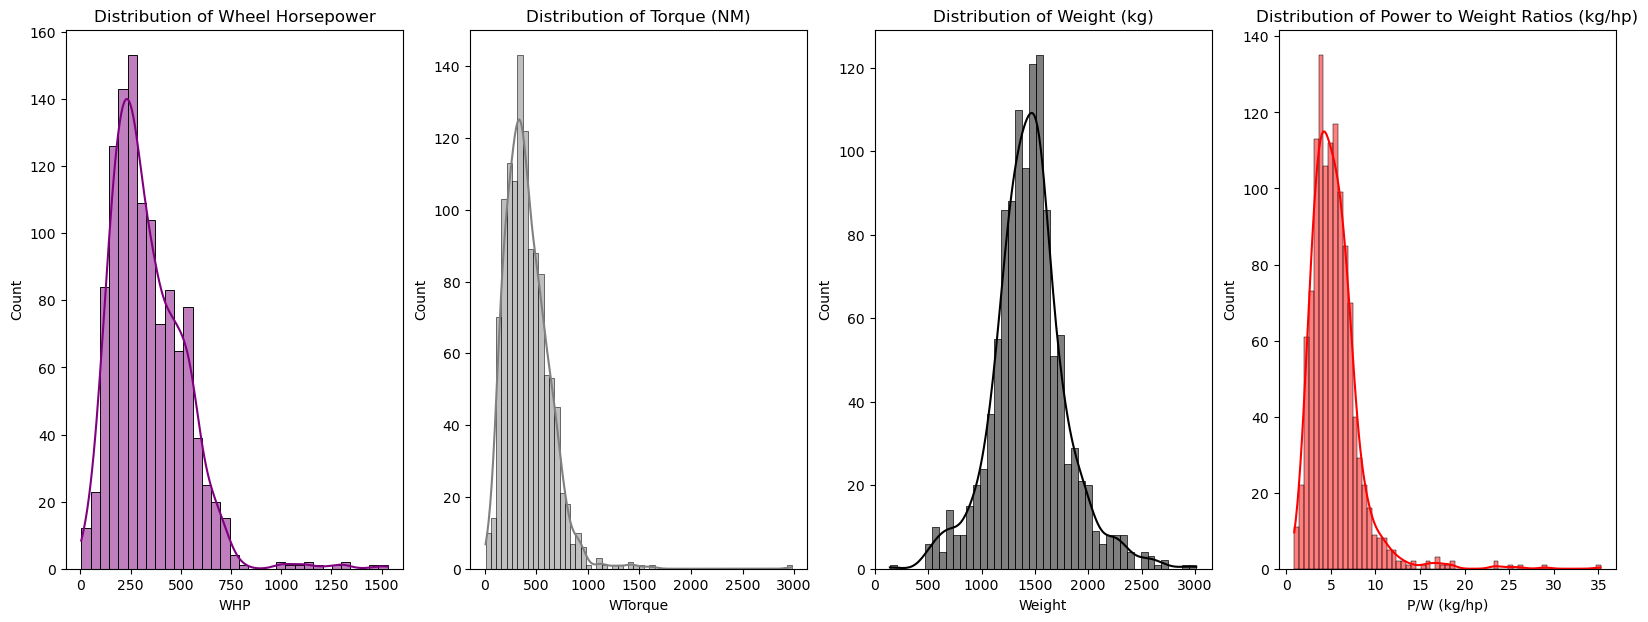

In [13]:
f, axes = plt.subplots(1, 4, figsize=(20,7))

z = sns.histplot(
    data=tsukuba,
    x='WHP',
    ax=axes[0],
    color="purple",
    kde=True,
    ).set(title="Distribution of Wheel Horsepower")

z2 = sns.histplot(
    data=tsukuba,
    x='WTorque',
    ax=axes[1],
    color="grey",
    kde=True,
    ).set(title="Distribution of Torque (NM)")

z1 = sns.histplot(
    data=tsukuba,
    x='Weight',
    ax=axes[2],
    color="black",
    kde=True,
    ).set(title="Distribution of Weight (kg)")

y = sns.histplot(
    data=tsukuba,
    x='P/W (kg/hp)',
    ax=axes[3],
    color="red",
    kde=True,
    ).set(title="Distribution of Power to Weight Ratios (kg/hp)")

In [25]:
display(pd.DataFrame(tsukuba.groupby('Brand').mean()).head())
display(pd.DataFrame(tsukuba.Brand.value_counts()).head())

,Year,RC,RC,RC.1,WHP,WTorque,Weight,P/W (kg/hp),Rating
Brand,,,,,,,,,
AMC,1971.000000,NaN,NaN,NaN,372.000000,583.000000,1475.000000,3.965054,NaN
Abarth,2004.714286,0.500000,1.0,NaN,144.285714,211.714286,1028.857143,8.333519,3.300000
Acura,2001.800000,0.142857,NaN,NaN,235.200000,245.500000,1377.300000,6.313763,3.142857
Alfa Romeo,1998.347826,0.312500,1.0,NaN,244.304348,317.739130,1286.217391,6.135357,3.266667
Alpina,2000.000000,NaN,NaN,NaN,309.200000,409.600000,1520.500000,5.429339,NaN


,Brand
BMW,103
Porsche,96
Honda,72
Mercedes-Benz,62
Ferrari,60
